# Compare the difference in elevation between DEM and Icesat-2 Data
REMA  

In [2]:
!cat /proc/meminfo | grep Mem

MemTotal:       131626564 kB
MemFree:        22359472 kB
MemAvailable:   106059968 kB


MemTotal:       197905012 kB
MemFree:        46727344 kB
MemAvailable:   193395012 kB


In [8]:
21835852/1e6

105.933988

In [1]:
# !cat /proc/cpuinfo | grep processor

In [2]:
%matplotlib inline

In [3]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (15, 8), 'font.size': 10})

from shapely.geometry import Polygon, Point
import hvplot
import geoviews as gv

import xarray as xr

import rasterio as rio
import hvplot.pandas
import hvplot.xarray

In [4]:
#base_region = #'REMA'

#data5: region_19_victoria_land  region_21_mbl_north  region_22_mbl_central     region_24_ctam
#data4: region_01_subantarctic_islands region_02_peninsula_north region_03_peninsula_south
#project: R:\REMA\region_20_ross_shelf\strips_unf\2m

region = 'region_03_peninsula_south'#'hma_2019jun26' #'region_20_ross_shelf'

In [5]:
# Select strips from icesat-2 because we know we have data (this is opposite of what we did in downloading data)
base_icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/{region}'

In [6]:
strips = os.listdir(base_icesat2_path)
len(strips)

102

In [7]:
strips

['GE01_20181022_1050010012B24800_1050010012B24A00_2m_lsf',
 'GE01_20181122_10500100133E2100_10500100133E2200_2m_lsf',
 'W1W1_20190406_1020010082B4AA00_10200100830E3500_2m_lsf',
 'WV01_20181212_102001007B3BC200_102001007CD19800_2m_lsf',
 'WV01_20181215_102001007E226D00_10200100809E6900_2m_lsf',
 'WV01_20181216_102001007CE33700_102001007B8DBC00_2m_lsf',
 'WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf',
 'WV01_20181220_102001007FBDCC00_102001007E29D200_2m_lsf',
 'WV01_20190102_102001007C8F2D00_102001007FE40B00_2m_lsf',
 'WV01_20181206_102001007C9A1400_102001007E5A1800_2m_lsf',
 'WV01_20190102_1020010082E1EA00_102001007E505300_2m_lsf',
 'WV01_20181217_102001007E386F00_102001008192F400_2m_lsf',
 'WV01_20181223_102001007C306A00_1020010080D79800_2m_lsf',
 'WV01_20181115_102001007C714F00_102001007C0F6A00_2m_lsf',
 'WV01_20190101_10200100821BF400_102001007D9F8B00_2m_lsf',
 'WV01_20181211_102001007CE61B00_102001007E42FF00_2m_lsf',
 'WV01_20190104_1020010081B86400_102001007C887800_2m_lsf

In [8]:
# Select a particular satellite, WV03 for example
strips = [strip for strip in strips if strip.startswith('WV03')]
len(strips)

21

In [9]:
# Set the icesat2_path : where files will be downloaded and processed (created inside code)
#base_icesat2_path = f'{dir_prefix}/icesat2/rema/{region}' # chage output folder
#base_icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/{region}' # hard-coded to data5; f'/fs/byo/howat-data5/icesat2/EarthDEM/{region}' FUTURE ref
#base_icesat2_path = f'/fs/byo/howat-data5/icesat2/hma/{region}' # hard-coded to data5; f'/fs/byo/howat-data5/icesat2/EarthDEM/{region}' FUTURE ref

In [10]:
# strip = 'GE01_20181122_10500100133E2100_10500100133E2200_2m_lsf' #'GE01_20181022_1050010012B24800_1050010012B24A00_2m_lsf'##
#icesat2_path = f'D:/icesat2/rema/region_03_peninsula_south_2/{strip}'
# icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/region_03_peninsula_south/{strip}'
strip = strips[5]
print(strip)
icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/{region}/{strip}'
os.path.exists(icesat2_path)

WV03_20181027_104001004420C800_104001004477D800_2m_lsf


True

In [11]:
icesat2_path

'/fs/byo/howat-data5/icesat2/rema/region_03_peninsula_south/WV03_20181027_104001004420C800_104001004477D800_2m_lsf'

In [12]:
files = os.listdir(f'{icesat2_path}')

In [13]:
files

['strip_outline.shp',
 'strip_outline.shx',
 'strip_outline.dbf',
 'strip_outline.cpg',
 'strip_outline.prj',
 'processed_ATL06_20181108185326_06280112_002_01.h5',
 'processed_ATL06_20181104061356_05590110_002_01.h5',
 'processed_ATL06_20181108185326_06280112_002_01.csv',
 'processed_ATL06_20181108185326_06280112_002_01.cpg',
 'processed_ATL06_20181104061356_05590110_002_01.csv',
 'processed_ATL06_20181104061356_05590110_002_01.cpg',
 'processed_ATL06_20181108185326_06280112_002_01.shp',
 'processed_ATL06_20181108185326_06280112_002_01.shx',
 'processed_ATL06_20181108185326_06280112_002_01.dbf',
 'processed_ATL06_20181108185326_06280112_002_01.prj',
 'processed_ATL06_20181104061356_05590110_002_01.shp',
 'processed_ATL06_20181104061356_05590110_002_01.shx',
 'processed_ATL06_20181104061356_05590110_002_01.dbf',
 'processed_ATL06_20181104061356_05590110_002_01.prj']

In [14]:
outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')
# hdf_files = [f for f in files if f.endswith('.h5')]
shp_files = [f for f in files if f.endswith('.shp') and 'ATL06' in f]
shp_files

['processed_ATL06_20181108185326_06280112_002_01.shp',
 'processed_ATL06_20181104061356_05590110_002_01.shp']

In [15]:
outline

,name,time1,time2,seg_id,geometry
0,WV03_20181027_104001004420C800_104001004477D80...,20181027125145,20181027125053,1,"POLYGON ((-62.55582 -71.86835, -62.55258 -70.9..."


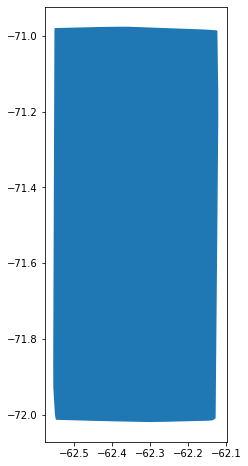

In [16]:
outline.plot()

## Now get the DEM (Rema for example)

In [17]:
#dir_prefix = '/fs/byo/howat-data5' #data4, 5 'D:' 'V:'
dir_prefix = '/fs/byo/howat-data4' #'/fs/project/howat.4' #/REMA/region_20_ross_shelf


In [18]:
strip

'WV03_20181027_104001004420C800_104001004477D800_2m_lsf'

In [19]:
# dem_folder = f'D:/REMA/region_03_peninsula_south/strips_unf/2m/{strip}'
dem_folder = f'{dir_prefix}/REMA/{region}/strips_unf/2m/{strip}'
tifs = [tif for tif in os.listdir(dem_folder) if tif.endswith('.tif')]
tifs

['WV03_20181027_104001004420C800_104001004477D800_2m_lsf_seg1_dem.tif',
 'WV03_20181027_104001004420C800_104001004477D800_2m_lsf_seg1_ortho.tif',
 'WV03_20181027_104001004420C800_104001004477D800_2m_lsf_seg1_dem_10m.tif',
 'WV03_20181027_104001004420C800_104001004477D800_2m_lsf_seg1_matchtag.tif',
 'WV03_20181027_104001004420C800_104001004477D800_2m_lsf_seg1_dem_browse.tif',
 'WV03_20181027_104001004420C800_104001004477D800_2m_lsf_seg1_bitmask.tif']

In [24]:
dem_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')][2]
dem_tif

IndexError: list index out of range

In [22]:
import georasters as grs

In [25]:
dem_tif = 'WV03_20181027_104001004420C800_104001004477D800_2m_lsf_seg1_dem_10m.tif'

In [26]:
dem = grs.from_file(f'{dem_folder}/{dem_tif}')

In [27]:
# use xarray only for visualization
da = xr.open_rasterio(f'{dem_folder}/{dem_tif}')
nodata_value = da.attrs['nodatavals'][0]
da.data[da.data==nodata_value] = np.nan
print(nodata_value)

-9999.0


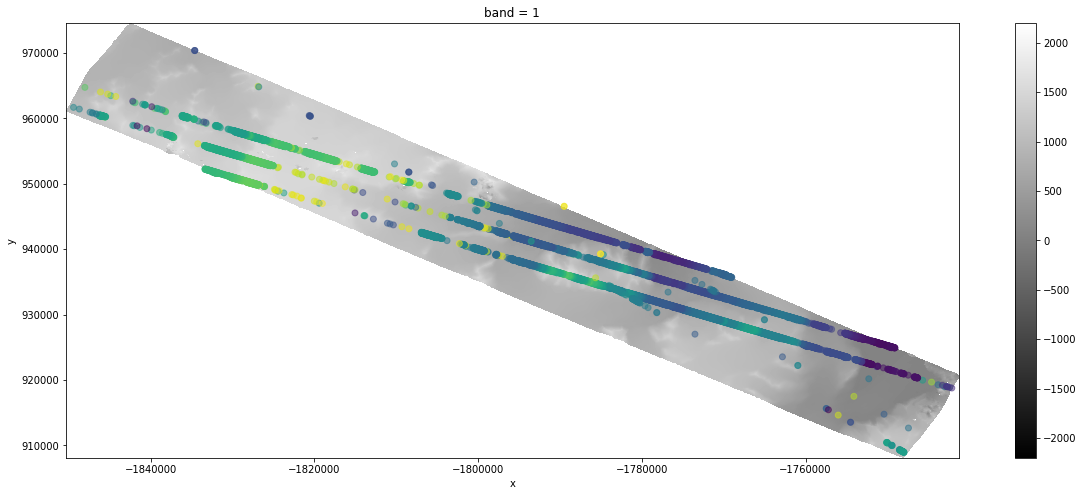

In [28]:
proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
# Read ATL Shapefile
fig, ax = plt.subplots(figsize=(20, 8))
for shp in shp_files:
    gdf = gpd.read_file(f'{icesat2_path}/{shp}')
    gdf = gdf.to_crs(proj4)
    gdf.plot(column='h_li', ax=ax, alpha=.5)
da.sel(band=1).plot.imshow(ax=ax, cmap='gray')
# dem.plot(ax=ax, cmap='gray')

In [27]:
len(shp_files)

4

processed_ATL06_20181108185326_06280112_002_01.shp
11036


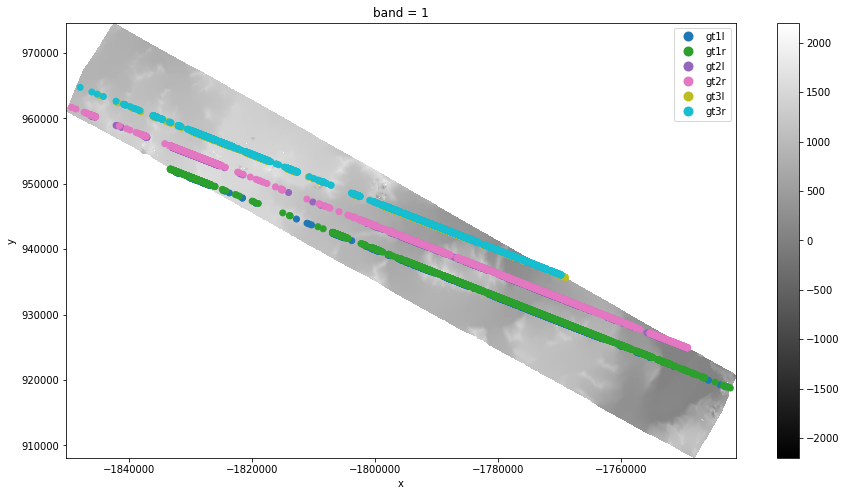

In [29]:
# Read ATL Shapefile
shp = shp_files[0]#'processed_ATL06_20181126061504_08950110_002_01.shp' [4, 6]
print(shp)
gdf = gpd.read_file(f'{icesat2_path}/{shp}')
print(len(gdf))

# Reproject the shapefile to that of REMA
proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
# proj4 = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #arcticDEM
# gdf = gdf.to_crs({'init': 'epsg:4326'}) #change to lat/longitude
gdf = gdf.to_crs(proj4)
ax = gdf.plot(column='strip', legend=True)
da.sel(band=1).plot.imshow(ax=ax, cmap='gray')
# gdf.head(2)

In [30]:
# print(dem.projection.ExportToPrettyWkt())

In [31]:
# Initilize dem elevlation
# gdf['dem'] = np.nan

In [32]:
def getPixVal(geom):
    #dem.map_pixel(x, y)
    coords = geom.coords[0]
    x, y = coords
    return(dem.map_pixel(x, y))

gdf['dem'] = gdf.geometry.apply(getPixVal)
# gdf = gdf.iloc[6:-10]
gdf['dif'] = gdf.h_li-gdf.dem

In [33]:
gdf

,t_dt,h_li,q_flag,strip,geometry,dem,dif
0,2018-11-08 18:55:54.693000,918.869202,1,gt1l,POINT (-1743019.376 918964.915),444.937164,473.932037
1,2018-11-08 18:55:54.814000,745.251770,1,gt1l,POINT (-1743820.016 919260.779),71.497528,673.754242
2,2018-11-08 18:55:55.099000,1140.592163,1,gt1l,POINT (-1745701.902 919952.356),67.580414,1073.011749
3,2018-11-08 18:55:55.950000,345.123535,1,gt1l,POINT (-1751325.803 922030.508),77.909668,267.213867
4,2018-11-08 18:55:56.229000,369.907471,1,gt1l,POINT (-1753171.084 922707.747),312.650482,57.256989
...,...,...,...,...,...,...,...
11031,2018-11-08 18:56:10.346000,327.354492,1,gt3r,POINT (-1842179.827 962606.775),1029.497803,-702.143311
11032,2018-11-08 18:56:10.654000,1982.256958,1,gt3r,POINT (-1844248.038 963327.647),1212.234131,770.022827
11033,2018-11-08 18:56:10.804000,1956.296021,1,gt3r,POINT (-1845238.776 963690.902),1048.357666,907.938354
11034,2018-11-08 18:56:10.936000,1967.146484,1,gt3r,POINT (-1846117.405 964012.962),999.488037,967.658447


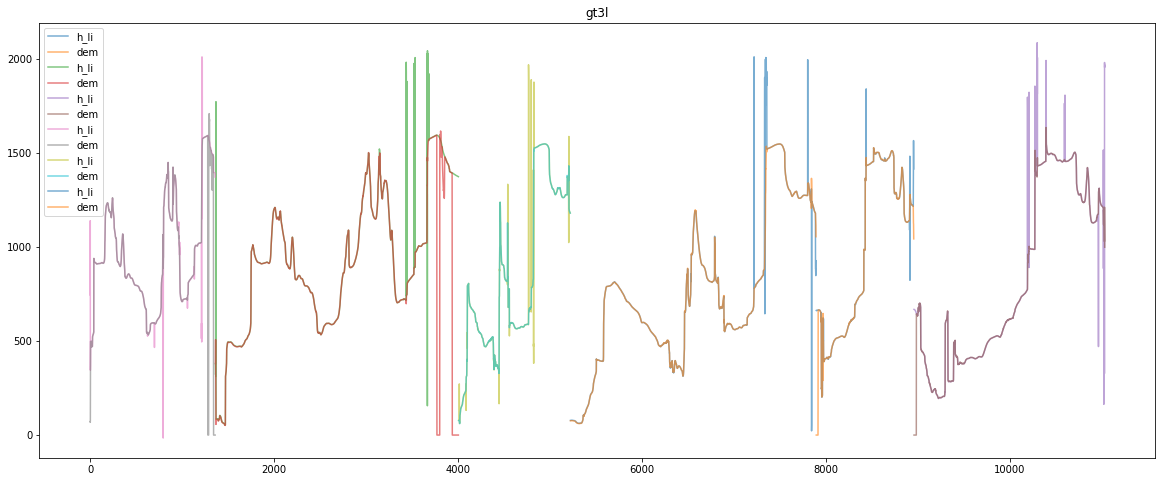

In [34]:
strips = list(gdf.strip.value_counts().index) #['gt1l', 'gt1r','gt2l', 'gt2r', 'gt3l','gt3r']
# strip = strips[2]
fig, ax = plt.subplots(figsize=(20, 8))
for strip in strips:
    gdf[gdf.strip==strip][['h_li', 'dem']].iloc[1:-1].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

In [35]:
# gdf.dif.plot()

In [36]:
gdf.strip.value_counts()

gt2r    2673
gt1r    2645
gt3r    2077
gt1l    1362
gt2l    1216
gt3l    1063
Name: strip, dtype: int64

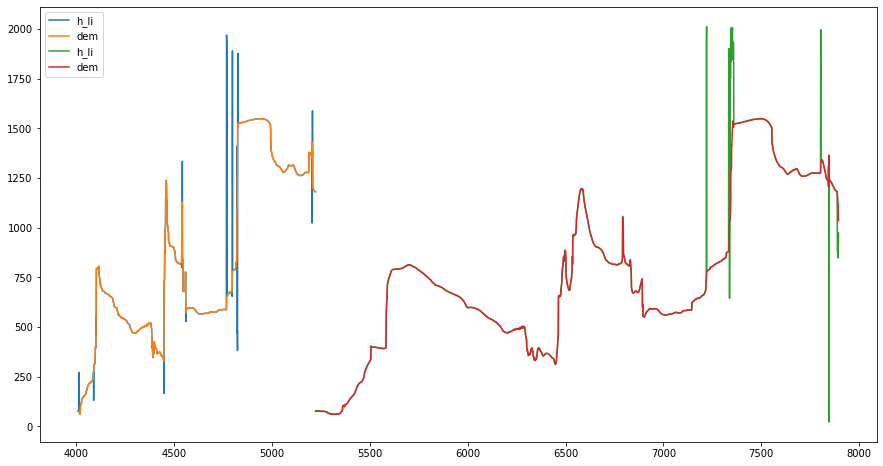

In [37]:
strip = 'gt2'
ax = gdf[gdf.strip==f'{strip}l'][['h_li', 'dem']].plot()
gdf[gdf.strip==f'{strip}r'][['h_li', 'dem']].plot(ax = ax)

In [39]:
gdf

,t_dt,h_li,q_flag,strip,geometry,dem,dif
0,2018-11-08 18:55:54.693000,918.869202,1,gt1l,POINT (-62.20064 -72.00813),444.937164,473.932037
1,2018-11-08 18:55:54.814000,745.251770,1,gt1l,POINT (-62.20389 -72.00053),71.497528,673.754242
2,2018-11-08 18:55:55.099000,1140.592163,1,gt1l,POINT (-62.21161 -71.98267),67.580414,1073.011749
3,2018-11-08 18:55:55.950000,345.123535,1,gt1l,POINT (-62.23428 -71.92925),77.909668,267.213867
4,2018-11-08 18:55:56.229000,369.907471,1,gt1l,POINT (-62.24181 -71.91174),312.650482,57.256989
...,...,...,...,...,...,...,...
11031,2018-11-08 18:56:10.346000,327.354492,1,gt3r,POINT (-62.41128 -71.03802),1029.497803,-702.143311
11032,2018-11-08 18:56:10.654000,1982.256958,1,gt3r,POINT (-62.42006 -71.01860),1212.234131,770.022827
11033,2018-11-08 18:56:10.804000,1956.296021,1,gt3r,POINT (-62.42382 -71.00922),1048.357666,907.938354
11034,2018-11-08 18:56:10.936000,1967.146484,1,gt3r,POINT (-62.42716 -71.00090),999.488037,967.658447


In [38]:
# Convert back to lat-lon for plotting
gdf = gdf.to_crs({'init': 'epsg:4326'})
gv.tile_sources.ESRI * gdf.hvplot(geo=True, color='strip', width=700, height=700)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (strip)

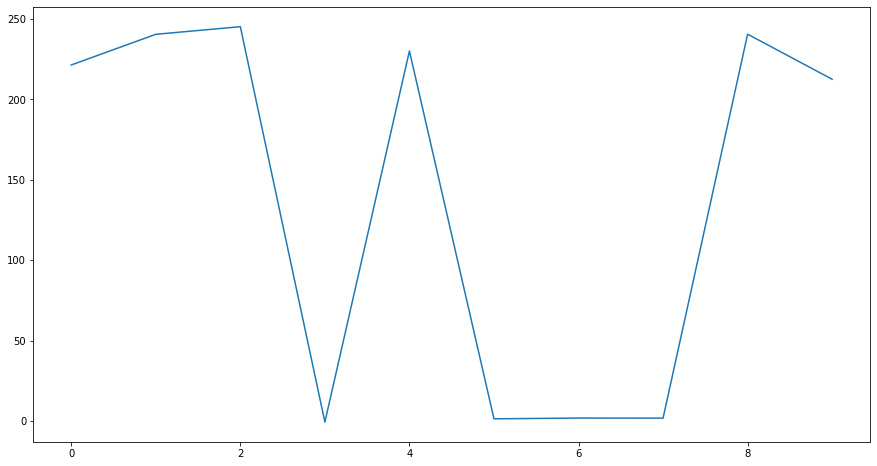

In [63]:
gdf[gdf.strip==f'{strip}r'].dif.plot()

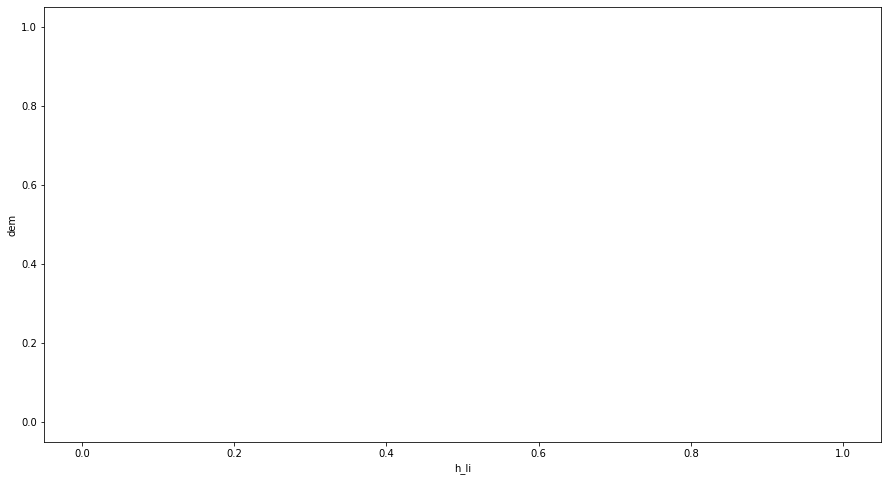

In [64]:
gdf[gdf.strip==f'{strip}l'][['h_li', 'dem']].iloc[2:-10].plot(kind='scatter', x=0, y=1)